# Entrega Final de Algotrading - Antonio Fuziy

___

Importando as bibliotecas utilizadas 

In [1]:
!pip install pandas-ta
!pip install yahoofinancials

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=55e00257297d99577cddbeacb2812c84620972173c0b427b4c6cb4d74d49938b
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for yahoofinancials: filename=yahoofinancials-1.14-py3-none-any.whl size=28627 sha256=5379144208142e8e019a973df01e8429fe7474f6052c58eb3647e86c452e4b20
  Stored in directory: /root/.cache/pip/wheels/32/a3/b6/b5b33187f2d42f095fecc236b957b46173fa09e7

In [2]:
!pip install pandas-ta
!pip install yahoofinancials

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import random
import yahoofinancials as yf
import pandas_ta as ta
from scipy.stats import spearmanr
from statsmodels.tsa.stattools import coint
import statsmodels.tsa.stattools as st
import pandas.testing as tm
from statsmodels.tsa.stattools import adfuller
import scipy.optimize as sco

from backtesting_v2_2 import evaluateHist, evaluateIntr, Strategy, Order, TradingSystem, MarketData, Event

plt.style.use("dark_background")

In [5]:
tickers = ["KO", "PEP", "F", "GM", "BBD", "ITUB"]

In [6]:
start_date = '2017-03-06'
end_date =  '2022-03-06'

for ticker in tickers:
    data = yf.YahooFinancials(ticker).get_historical_price_data(start_date, end_date, 'daily')
    raw = pd.DataFrame(data[ticker]['prices']).dropna()
    raw['formatted_date'] = pd.to_datetime(raw['formatted_date'])
    raw = raw.set_index('formatted_date')
    df = raw.iloc[:,1:]
    df = df.reindex(columns=['open', 'high', 'low', 'close', 'adjclose', 'volume'])
    df.to_csv('{}.csv'.format(ticker))

In [7]:
df = pd.read_csv('{}.csv'.format(ticker))
df.head()

,formatted_date,open,high,low,close,adjclose,volume
0,2017-03-06,7.062380,7.078868,6.963451,6.996428,5.205882,10685014
1,2017-03-07,7.029404,7.034900,6.886507,6.908491,5.140452,11935920
2,2017-03-08,6.787579,6.859027,6.677659,6.754603,5.025948,14880053
3,2017-03-09,6.727123,6.776587,6.650179,6.710635,4.993232,17339835
4,2017-03-10,6.886507,6.886507,6.760099,6.815059,5.070931,14854398


In [8]:
def get_indicator(prices, array_indicator, indicator, period, side):
    signal_indicator = 0
    ppo_fast = 12
    ppo_slow = 26
    ppo_signal = 9
    ppo_scalar = 100
    ppo_signal = 0
    m = 0
    
    if indicator == "CMO":
        if len(prices) >= period + 1:
            close = pd.DataFrame({'close': prices})
            cmo = close.ta.cmo(length=period)
            array_indicator.append([cmo.iloc[-1]])

            cmo_value = cmo.iloc[-1]

            if cmo_value >= 50: 
                signal_indicator = -1
            elif cmo_value <= -50:
                signal_indicator = 1
            else:
                signal_indicator = 0
    
    if indicator == "PPO":
        if len(prices) >= ppo_slow + ppo_signal:
            close = pd.DataFrame({'close': prices})

            ppo = close.ta.ppo(fast=ppo_fast, slow=ppo_slow, signal=ppo_signal, scalar=ppo_scalar)

            array_indicator.append([ppo.iloc[-1, 0], ppo.iloc[-1, 2]])

            signal_indicator = ppo.iloc[-1, 0] > ppo.iloc[-1, 2]
            
    if indicator == "BBANDS":
        if len(prices) >= period + 1:
            close = pd.DataFrame({'close': prices})
            
            bbands = close.ta.bbands(lenght = period, std = m)            
            
            down = bbands.iloc[-1, 0]
            avg = bbands.iloc[-1, 1]
            up = bbands.iloc[-1, 2]
            
            array_indicator.append([up, avg, down])

            if prices[-1] < down:
                bbands_signal = -1 
            elif prices[-1] > up:
                bbands_signal = 1
            elif prices[-1] > avg and side == -1:
                bbands_signal = 0
            elif prices[-1] < avg and side == 1:
                bbands_signal = 0
            else:
                bbands_signal = side

    return signal_indicator, array_indicator

In [14]:
class FuziyStrategy(Strategy):

    def __init__(self, ticker1, ticker2):
        self.period = 14
        
        self.sell_signals1 = []
        self.buy_signals1 = []
        self.sell_indexes1 = []
        self.buy_indexes1 = []
        
        self.sell_signals2 = []
        self.buy_signals2 = []
        self.sell_indexes2 = []
        self.buy_indexes2 = []

        self.prices1 = []
        self.prices2 = []
        
        self.coint_indicator = []
        self.pvalues = []
        self.coint_signal = 0
        
        self.ticker1 = ticker1
        self.ticker2 = ticker2
        
        self.tam = 126
        
        self.side = 0
        self.signal = 0
        
        self.qty1 = 0
        self.qty2 = 0
        
        #====================================================================
        #CMO PARAMETERS
        #====================================================================
        self.cmo_indicator1 = []
        self.cmo_indicator2 = []
        self.cmo_signal1 = 0
        self.cmo_signal2 = 0
        
        self.init_capital = 100000
        self.avail_capital = self.init_capital
        
        self.combined_signals = 0
        
    def receive(self, event):
        
        orders = []
        
        if event.instrument == self.ticker1:
            self.prices1.append(event.price[3])
        elif event.instrument == self.ticker2:
            self.prices2.append(event.price[3])
        
        tam = min(len(self.prices1), len(self.prices2))
        if tam >= self.tam and len(self.prices1) == len(self.prices2):
            y = self.prices1[-self.tam:]
            x = self.prices2[-self.tam:]
            
            _, pvalue, _ = coint(x, y)
            self.pvalues.append(pvalue)

            model = st.OLS(y,x)
            results = model.fit()
            self.coint_indicator.append(results.resid[-1])
            
            self.coint_signal = self.side
            
            if self.coint_signal < 0 and results.resid[-1] < 0: 
                self.coint_signal = 0
            elif self.coint_signal > 0 and results.resid[-1] > 0: 
                self.coint_signal = 0
                
            elif pvalue < 1 and len(self.coint_indicator) > self.tam: 
                
                if results.resid[-1] < -2*np.std(self.coint_indicator[-self.tam:]):
                    self.coint_signal = 1
                elif results.resid[-1] > 2*np.std(self.coint_indicator[-self.tam:]):
                    self.coint_signal = -1
        
            self.cmo_signal1, self.cmo_indicator1 = get_indicator(self.prices1, self.cmo_indicator1, "CMO", self.period, self.side)
            self.cmo_signal2, self.cmo_indicator2 = get_indicator(self.prices2, self.cmo_indicator2, "CMO", self.period, self.side)

            self.combined_signals = self.cmo_signal1 + self.cmo_signal2 + self.coint_signal

            if self.combined_signals >= 2:
                self.signal = 1
            elif self.combined_signals <= -2:
                self.signal = -1
            else:
                self.signal = 0
                    
            if self.side != self.signal:
                
                if self.qty1 > 0:
                    self.submit(self.id, Order(self.ticker1, Order.S, self.qty1, 0))
                elif self.qty1 < 0: 
                    self.submit(self.id, Order(self.ticker1, Order.B, self.qty1, 0))
                
                if self.qty2 > 0:
                    self.submit(self.id, Order(self.ticker2, Order.S, self.qty2, 0))
                elif self.qty2 < 0: 
                    self.submit(self.id, Order(self.ticker2, Order.B, self.qty2, 0))
                    
                self.qty2 = 100 * self.signal
                self.qty1 = -int(100 / results.params[0]) * self.signal
               
                if self.qty1 > 0:
                    self.submit(self.id, Order(self.ticker1, Order.B, self.qty1, 0))
#                     print(f"compra {self.ticker1} +{self.qty1}")
#                     print(f"price: {self.prices1[-1]} index: {len(self.prices1)}")
                    self.buy_signals1.append(self.prices1[-1])
                    self.buy_indexes1.append(len(self.prices1))
                elif self.qty1 < 0: 
                    self.submit(self.id, Order(self.ticker1, Order.SS, self.qty1, 0))
#                     print(f"vende {self.ticker1} -{self.qty1}")
#                     print(f"price: {self.prices1[-1]} index: {len(self.prices1)}")
                    self.sell_signals1.append(self.prices1[-1])
                    self.sell_indexes1.append(len(self.prices1))
                
                if self.qty2 > 0:
                    self.submit(self.id, Order(self.ticker2, Order.B, self.qty2, 0))
#                     print(f"compra {self.ticker2} +{self.qty2}")
#                     print(f"price: {self.prices2[-1]} index: {len(self.prices2)}")
                    self.buy_signals2.append(self.prices2[-1])
                    self.buy_indexes2.append(len(self.prices2))
                elif self.qty2 < 0: 
                    self.submit(self.id, Order(self.ticker2, Order.SS, self.qty2, 0))
#                     print(f"vende {self.ticker2} -{self.qty2}")
#                     print(f"price: {self.prices2[-1]} index: {len(self.prices2)}")
                    self.sell_signals2.append(self.prices2[-1])
                    self.sell_indexes2.append(len(self.prices2))

                self.side = self.signal                
            
    def fill(self, id, instrument, price, quantity, status):
        if quantity != 0:
            print('Fill: {0} {1}@{2}'.format(instrument, quantity, price))

In [15]:
fuziy_strategy = FuziyStrategy('BBD', 'ITUB')

print(evaluateHist(fuziy_strategy, {'BBD': 'BBD.csv', 'ITUB': 'ITUB.csv'}))

Fill: BBD 80@7.621605396270752
Fill: ITUB -100@6.153432369232178
Fill: BBD -80@7.667680263519287
Fill: ITUB 100@6.203392505645752
Fill: BBD 80@8.312686920166016
Fill: ITUB -100@6.702993869781494
Fill: BBD -80@8.220538139343262
Fill: ITUB 100@6.765443801879883
Fill: BBD -88@4.649195671081543
Fill: ITUB 100@4.586234092712402
Fill: BBD 88@4.8605217933654785
Fill: ITUB -100@4.812717914581299
Fill: BBD 98@5.803755760192871
Fill: ITUB -100@5.8744354248046875
Fill: BBD -98@5.636979103088379
Fill: ITUB 100@5.648324489593506
Fill: BBD 93@8.468521118164062
Fill: ITUB -100@7.086623668670654
Fill: BBD -93@8.332147598266602
Fill: ITUB 100@7.049313068389893
Fill: BBD -86@5.324139595031738
Fill: ITUB 100@4.766958713531494
Fill: BBD 86@4.523778915405273
Fill: ITUB -100@4.089157581329346
Fill: BBD 96@4.902935981750488
Fill: ITUB -100@4.69891357421875
Fill: BBD -96@4.843841075897217
Fill: ITUB 100@4.6912617683410645
Fill: BBD 96@4.9691925048828125
Fill: ITUB -100@4.8519721031188965
Fill: BBD -96@4.90651

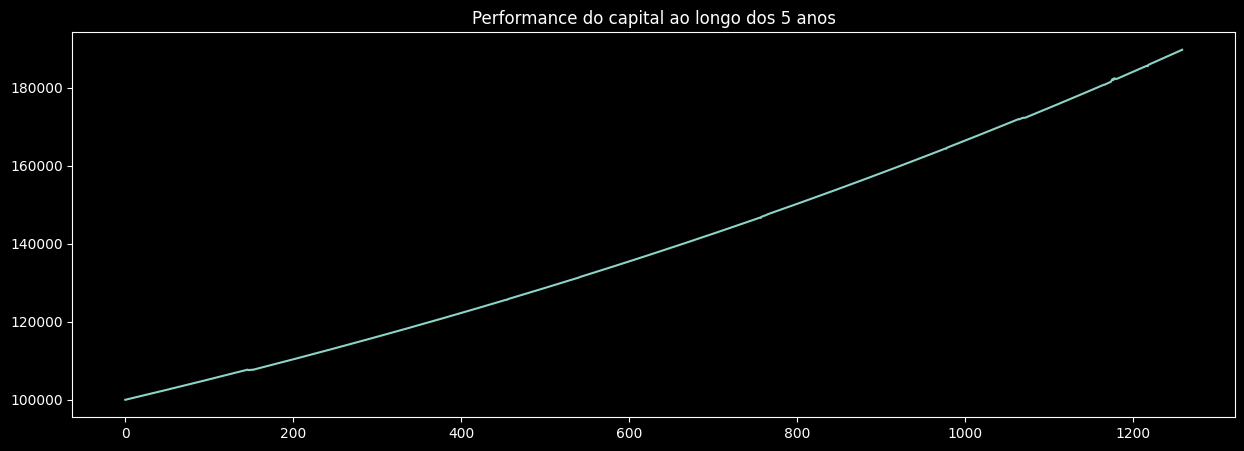

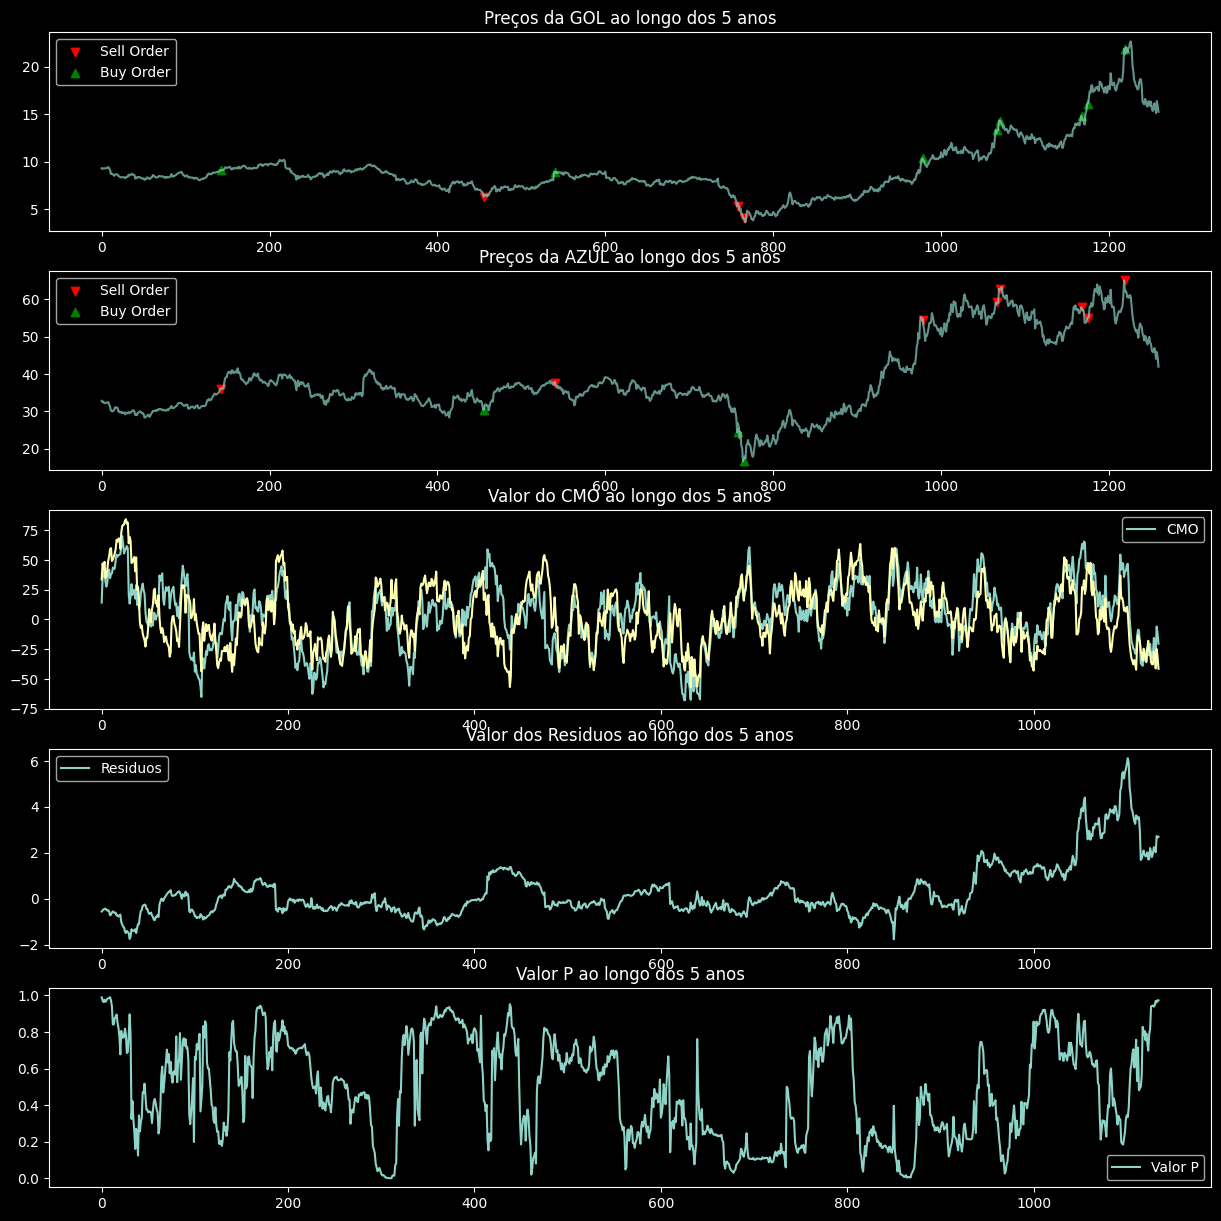

In [19]:
plt.figure(figsize=(15,5))
plt.plot([day[0] for day in fuziy_strategy._days.values()])
plt.title("Performance do capital ao longo dos 5 anos")
plt.show()

plt.figure(figsize=(15,15))

plt.subplot(5,1,1)
plt.plot(fuziy_strategy.prices1, alpha=0.7)
plt.scatter(fuziy_strategy.sell_indexes1, fuziy_strategy.sell_signals1, marker="v", color="red", label="Sell Order")
plt.scatter(fuziy_strategy.buy_indexes1, fuziy_strategy.buy_signals1, marker="^", color="green", label="Buy Order")
plt.legend()
plt.title("Preços da GOL ao longo dos 5 anos")

plt.subplot(5,1,2)
plt.plot(fuziy_strategy.prices2, alpha=0.7)
plt.scatter(fuziy_strategy.sell_indexes2, fuziy_strategy.sell_signals2, marker="v", color="red", label="Sell Order")
plt.scatter(fuziy_strategy.buy_indexes2, fuziy_strategy.buy_signals2, marker="^", color="green", label="Buy Order")
plt.legend()
plt.title("Preços da AZUL ao longo dos 5 anos")

plt.subplot(5,1,3)
plt.plot(fuziy_strategy.cmo_indicator1)
plt.plot(fuziy_strategy.cmo_indicator2)
plt.legend(['CMO']);
plt.title("Valor do CMO ao longo dos 5 anos")

plt.subplot(5,1,4)
plt.plot(fuziy_strategy.coint_indicator)
plt.legend(['Residuos']);
plt.title("Valor dos Residuos ao longo dos 5 anos")

plt.subplot(5,1,5)
plt.plot(fuziy_strategy.pvalues)
plt.legend(['Valor P']);
plt.title("Valor P ao longo dos 5 anos")

plt.show()

In [17]:
fuziy_strategy = FuziyStrategy('F', 'GM')

print(evaluateHist(fuziy_strategy, {'F': 'F.csv', 'GM': 'GM.csv'}))

Fill: F 366@9.082391738891602
Fill: GM -100@36.02716827392578
Fill: F -366@9.21930980682373
Fill: GM 100@40.130516052246094
Fill: F -426@6.298379421234131
Fill: GM 100@30.395793914794922
Fill: F 426@6.479983329772949
Fill: GM -100@31.475658416748047
Fill: F 475@8.88316822052002
Fill: GM -100@37.62974166870117
Fill: F -475@8.789301872253418
Fill: GM 100@36.74779510498047
Fill: F -448@5.281979084014893
Fill: GM 100@24.45387077331543
Fill: F 448@5.604269981384277
Fill: GM -100@26.86063003540039
Fill: F -448@4.028628349304199
Fill: GM 100@16.639328002929688
Fill: F 448@4.00177001953125
Fill: GM -100@17.540624618530273
Fill: F 507@10.322240829467773
Fill: GM -100@54.55323028564453
Fill: F -507@10.107380867004395
Fill: GM 100@52.87938690185547
Fill: F 517@13.321331024169922
Fill: GM -100@59.1983757019043
Fill: F -517@13.0079927444458
Fill: GM 100@58.74277114868164
Fill: F 513@14.315059661865234
Fill: GM -100@62.85308074951172
Fill: F -513@13.992768287658691
Fill: GM 100@63.30868148803711
Fil

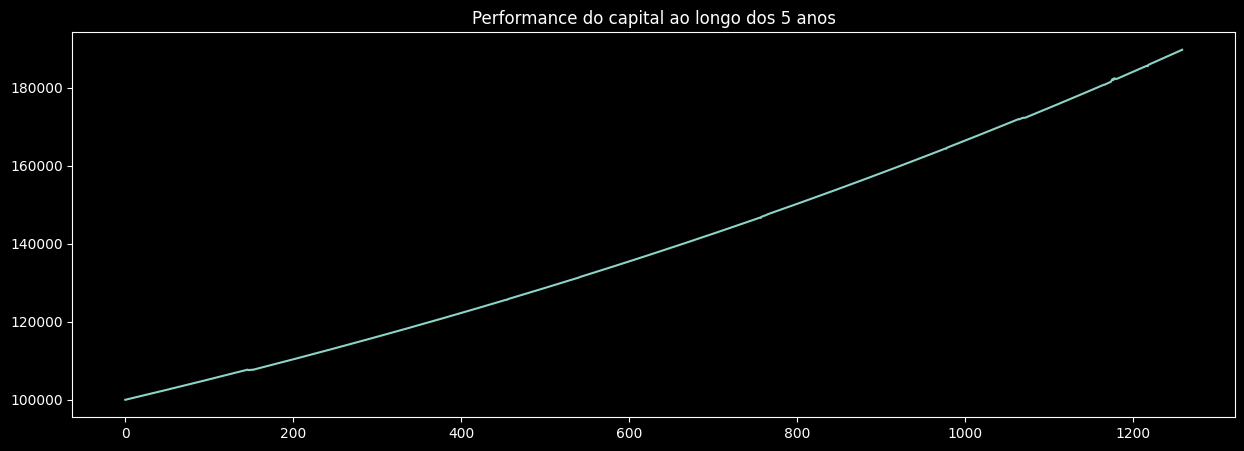

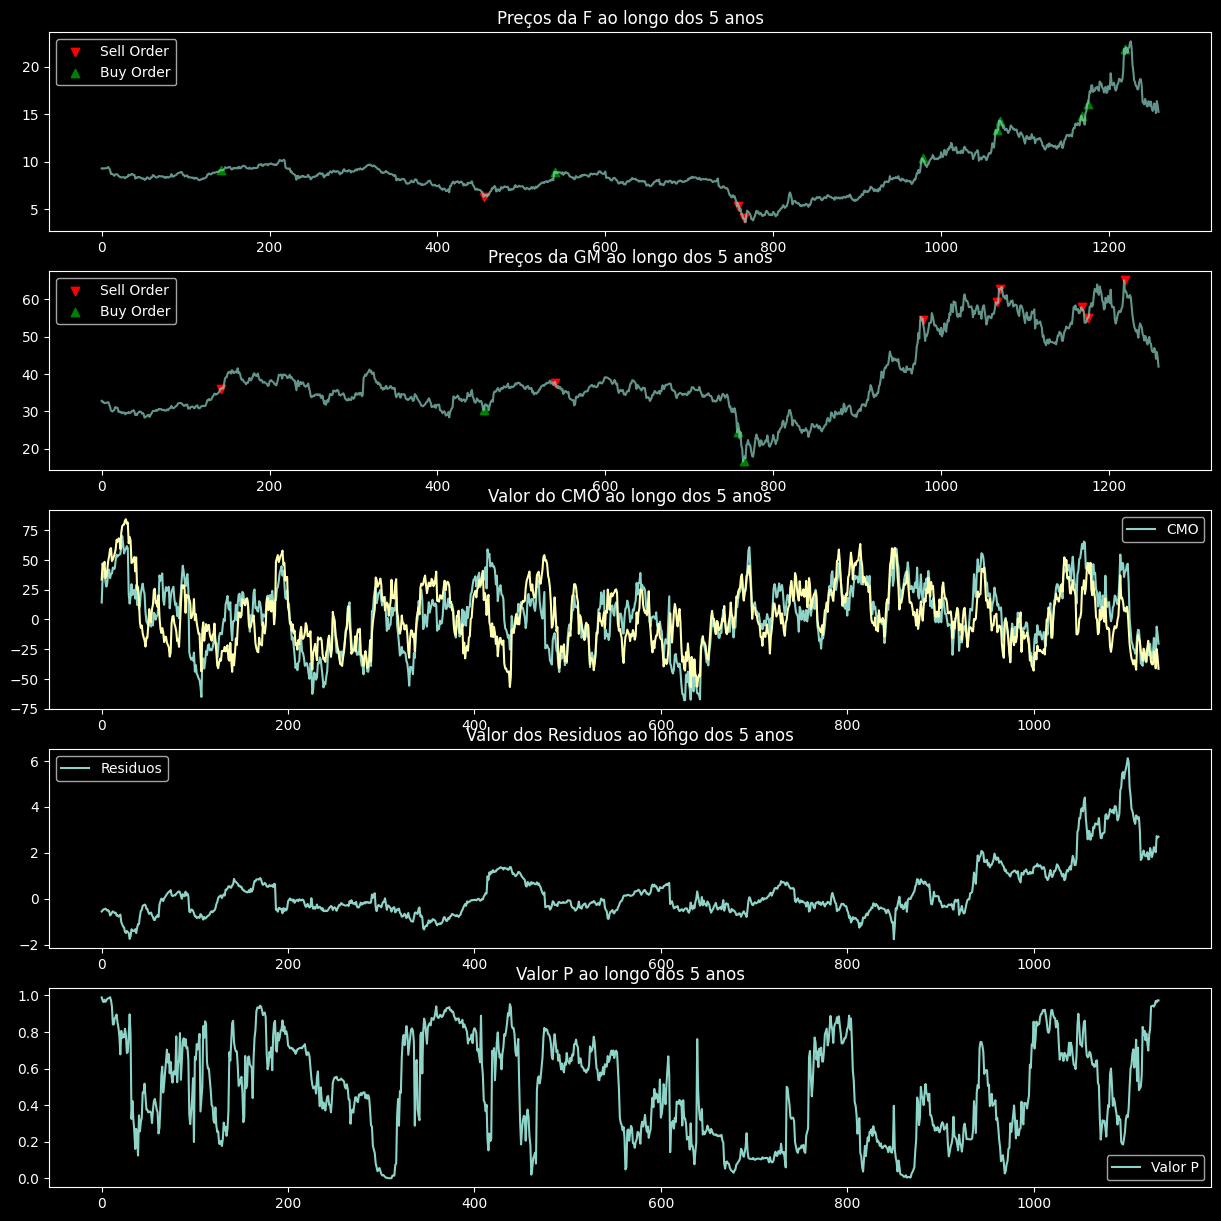

In [20]:
plt.figure(figsize=(15,5))
plt.plot([day[0] for day in fuziy_strategy._days.values()])
plt.title("Performance do capital ao longo dos 5 anos")
plt.show()

plt.figure(figsize=(15,15))

plt.subplot(5,1,1)
plt.plot(fuziy_strategy.prices1, alpha=0.7)
plt.scatter(fuziy_strategy.sell_indexes1, fuziy_strategy.sell_signals1, marker="v", color="red", label="Sell Order")
plt.scatter(fuziy_strategy.buy_indexes1, fuziy_strategy.buy_signals1, marker="^", color="green", label="Buy Order")
plt.legend()
plt.title("Preços da F ao longo dos 5 anos")

plt.subplot(5,1,2)
plt.plot(fuziy_strategy.prices2, alpha=0.7)
plt.scatter(fuziy_strategy.sell_indexes2, fuziy_strategy.sell_signals2, marker="v", color="red", label="Sell Order")
plt.scatter(fuziy_strategy.buy_indexes2, fuziy_strategy.buy_signals2, marker="^", color="green", label="Buy Order")
plt.legend()
plt.title("Preços da GM ao longo dos 5 anos")

plt.subplot(5,1,3)
plt.plot(fuziy_strategy.cmo_indicator1)
plt.plot(fuziy_strategy.cmo_indicator2)
plt.legend(['CMO']);
plt.title("Valor do CMO ao longo dos 5 anos")

plt.subplot(5,1,4)
plt.plot(fuziy_strategy.coint_indicator)
plt.legend(['Residuos']);
plt.title("Valor dos Residuos ao longo dos 5 anos")

plt.subplot(5,1,5)
plt.plot(fuziy_strategy.pvalues)
plt.legend(['Valor P']);
plt.title("Valor P ao longo dos 5 anos")

plt.show()